# 01 - Data Preparation

This notebook covers:
1. Loading and preprocessing the PBMC-33k dataset (10x Genomics)
2. Quality control (QC) filtering, normalization, HVG selection
3. Clustering (PCA, neighbors, UMAP, Leiden)
4. Visualize clusters and identify rare cell types

In [70]:
import sys
sys.path.insert(0, '../src')

import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from utils import set_global_seed, GLOBAL_SEED, Timer
from data import load_and_preprocess_pbmc

set_global_seed(GLOBAL_SEED)

sc.settings.verbosity = 2
sc.settings.n_jobs = 1

DATA_DIR = Path('../data')
RAW_DATA_PATH = DATA_DIR / 'filtered_gene_bc_matrices/hg19'
PROCESSED_PATH = DATA_DIR / 'adata_processed.h5ad'

print(f"Global seed: {GLOBAL_SEED}")
print(f"Raw data path: {RAW_DATA_PATH}")

Global seed: 42
Raw data path: ../data/filtered_gene_bc_matrices/hg19


## Load and Preprocess Data

Using `load_and_preprocess_pbmc()` from src/data.py:
- Loading 10x data from matrix.mtx format
- QC filtering (min genes, max mito %)
- Normalization (CP10K + log1p)
- HVG selection (Seurat v3 method, 2000 genes)

In [71]:
with Timer("Data preprocessing"):
    adata, _ = load_and_preprocess_pbmc(  # Ignore auto splits
        data_path=str(RAW_DATA_PATH),
        output_path=str(PROCESSED_PATH),
        min_genes=200,
        max_mito_pct=10.0,
        n_top_genes=2000,
        seed=GLOBAL_SEED
    )

print(f"\nProcessed data shape: {adata.shape}")

[Data preprocessing] Starting at 22:18:17
Loading 10x data from ../data/filtered_gene_bc_matrices/hg19
... reading from cache file cache/..-data-filtered_gene_bc_matrices-hg19-matrix.h5ad
Loaded 33148 cells × 32738 genes
Applying QC filters...
  Min genes per cell: 200
  Max mitochondrial %: 10.0
filtered out 7 cells that have less than 200 genes expressed
  Cells before QC: 33148
  Cells after QC: 33088
  Cells removed: 60 (0.2%)
Normalizing and selecting HVGs...
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/Users/dbenson/.pyenv/versions/stat4243/lib/python3.12/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


  Selected 2000 highly variable genes
  Final shape: 33088 cells × 2000 genes
Creating train/val/test splits...
  Train: 20844 cells
  Val: 4964 cells
  Test: 4964 cells
  Holdout (T ⊂ R for retraining equivalence): 2316 cells

Processed data saved to ../data/adata_processed.h5ad
[Data preprocessing] Completed in 3.31 seconds

Processed data shape: (33088, 2000)


## Clustering

Run PCA, compute neighbors, UMAP embedding, and Leiden clustering.

In [72]:
with Timer("Clustering"):
    # PCA
    sc.tl.pca(adata, n_comps=50, svd_solver='arpack')
    
    # Neighbors
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
    
    # UMAP
    sc.tl.umap(adata)
    
    # Leiden clustering
    sc.tl.leiden(adata, resolution=0.5, key_added='leiden')

print(f"\nNumber of clusters: {adata.obs['leiden'].nunique()}")
print("\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

[Clustering] Starting at 22:18:20
computing PCA
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:04)
computing UMAP
    finished (0:00:21)
running Leiden clustering
    finished (0:00:23)
[Clustering] Completed in 53.42 seconds

Number of clusters: 14

Cluster sizes:
leiden
0     6882
1     6233
2     5567
3     4521
4     4050
5     2277
6     2141
7      477
8      309
9      235
10     221
11      85
12      55
13      35
Name: count, dtype: int64


In [73]:
adata.write_h5ad(PROCESSED_PATH)
print(f"Saved processed data with clustering to {PROCESSED_PATH}")

Saved processed data with clustering to ../data/adata_processed.h5ad


## Visualize Clusters

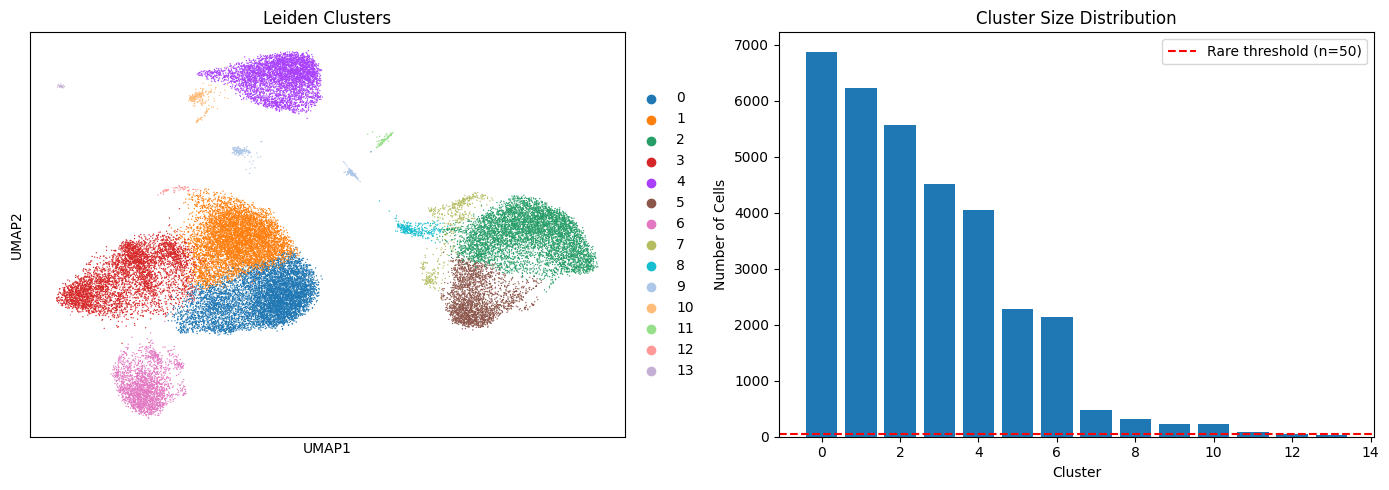


Rare clusters (n < 50): ['13']
  Cluster 13: 35 cells


In [74]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# UMAP colored by cluster
sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clusters')

cluster_counts = adata.obs['leiden'].value_counts().sort_index()
axes[1].bar(range(len(cluster_counts)), cluster_counts.values)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Cells')
axes[1].set_title('Cluster Size Distribution')
axes[1].axhline(y=50, color='r', linestyle='--', label='Rare threshold (n=50)')
axes[1].legend()

plt.tight_layout()
plt.show()

rare_clusters = cluster_counts[cluster_counts < 50]
print(f"\nRare clusters (n < 50): {list(rare_clusters.index)}")
for c, n in rare_clusters.items():
    print(f"  Cluster {c}: {n} cells")

## Summary

| Output | Path |
|--------|------|
| Processed data | `data/adata_processed.h5ad` |

Key observations:
- 33,088 cells, 2,000 HVGs
- 14 Leiden clusters
- Cluster 13 is the smallest (35 cells) - candidate for structured forget set

**Next**: `02_baseline_vae.ipynb` - Create splits and train baseline VAE